In [ ]:
!pip install do_mpc
import do_mpc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
from IPython.display import HTML, display
from casadi import SX, vertcat
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## One agent

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from casadi import SX
import do_mpc
from IPython.display import HTML

# Define parameters
target_noise = 0.1
horizon = 1
cost = 1
catch_threshold = 0.01  # Threshold for catching the target (distance)
n_steps = 100
update_interval = 5  # Update the trajectory every 5 steps

# Define model
def create_model():
    model_type = 'continuous'
    model = do_mpc.model.Model(model_type)

    # States (target: x_t, y_t | agent: x_a, y_a)
    x_t = model.set_variable(var_type='_x', var_name='x_t', shape=(1,1))
    y_t = model.set_variable(var_type='_x', var_name='y_t', shape=(1,1))
    x_a = model.set_variable(var_type='_x', var_name='x_a', shape=(1,1))
    y_a = model.set_variable(var_type='_x', var_name='y_a', shape=(1,1))

    # Controls (velocity for the agent)
    u_x = model.set_variable(var_type='_u', var_name='u_x', shape=(1,1))
    u_y = model.set_variable(var_type='_u', var_name='u_y', shape=(1,1))

    # Target moves predictably
    v_t = SX(0.2)  # Constant velocity as a CasADi SX variable
    x_t_dot = v_t*1  # Moves to the right
    y_t_dot = v_t*1  # Moves up

    # State equations
    model.set_rhs('x_a', u_x)
    model.set_rhs('y_a', u_y)
    model.set_rhs('x_t', x_t_dot)
    model.set_rhs('y_t', y_t_dot)

    model.setup()
    return model

# Create MPC controller
def create_mpc(model, horizon):
    mpc = do_mpc.controller.MPC(model)
    setup_mpc = {
        'n_horizon': horizon,
        't_step': 0.1,
        'n_robust': 0,
        'store_full_solution': True,
    }
    mpc.set_param(**setup_mpc)

    # Define cost function
    x_a, y_a, x_t, y_t = model.x['x_a'], model.x['y_a'], model.x['x_t'], model.x['y_t']

    goal_cost = cost*(x_a - x_t)**2 + cost*(y_a - y_t)**2

    mpc.set_objective(mterm=goal_cost, lterm=goal_cost)

    # Control bounds
    mpc.bounds['lower', '_u', 'u_x'] = -0.3
    mpc.bounds['upper', '_u', 'u_x'] = 0.3
    mpc.bounds['lower', '_u', 'u_y'] = -0.3
    mpc.bounds['upper', '_u', 'u_y'] = 0.3

    mpc.setup()
    return mpc

# Create simulator
def create_simulator(model):
    simulator = do_mpc.simulator.Simulator(model)
    simulator.set_param(t_step=0.1)
    simulator.setup()
    return simulator

# Initialize model, controller, and simulator
model = create_model()
mpc = create_mpc(model, horizon)
simulator = create_simulator(model)

# Initial state
x0 = np.array([[0.0], [0.0], [0.0], [1.0]])  # Blue at (0,0), Red at (1,1)
mpc.x0 = x0
simulator.x0 = x0
mpc.set_initial_guess()

# Simulate
data = []
x_current = x0
caught = False
catch_time = None
counter = 0
for step in range(n_steps):
    if counter % update_interval == 0:  # Only compute the optimal control every 'update_interval' steps
        u = mpc.make_step(x_current)  # Recompute control trajectory
    else:
        # Use the same control input as the previous step
        u = mpc.u0  # Using the previous control input

    x_current = simulator.make_step(u)  # Apply the control input to the simulator
    counter += 1

    # Add noise to the target's movement (but NOT to the agent)
    np.random.seed(42)  # First call's seed
    x_current[0] += np.random.normal(0, target_noise)

    np.random.seed(43)  # Second call's seed
    x_current[1] += np.random.normal(0, target_noise)

    # Check if agent caught the target
    distance = np.sqrt((x_current[2] - x_current[0])**2 + (x_current[3] - x_current[1])**2)
    if not caught and distance < catch_threshold:
        caught = True
        catch_time = step

    data.append(x_current)

data = np.array(data).squeeze()

# Animation
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Prepare title with catch time, noise, horizon, and update interval
if caught:
    title = f"Catch: {catch_time}|Noise: {target_noise}|Horizon: {horizon}|Update: {update_interval}"
else:
    title = f"Not Caught|Noise: {target_noise}|Horizon: {horizon}|Update: {update_interval}"

ax.set_title(title)

agent, = ax.plot([], [], 'bo', markersize=8, label="Agent")
target, = ax.plot([], [], 'ro', markersize=8, label="Target")
# ax.legend()

def update(frame):
    target.set_data([data[frame, 0]], [data[frame, 1]])  # Wrap values in lists
    agent.set_data([data[frame, 2]], [data[frame, 3]])
    return agent, target

ani = animation.FuncAnimation(fig, update, frames=n_steps, interval=100, blit=True)

plt.close(fig)  # Prevents static display
display(HTML(ani.to_html5_video()))  # Displays only the video


/usr/local/lib/python3.11/dist-packages/do_mpc/controller/_mpc.py:885: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       48
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       12

Total number of variables............................:       34
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e+00 2.00e-02 1.94e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

# Many agents

/usr/local/lib/python3.11/dist-packages/do_mpc/controller/_mpc.py:885: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


Streaming output truncated to the last 5000 lines.
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8738339e-03 3.27e-02 5.99e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.4116913e-02 2.41e-15 3.27e-06  -1.7 3.27e-02  -4.0 1.00e+00 1.00e+00h  1
   2  6.0460414e-03 3.12e-15 5.79e-07  -2.5 1.74e-02  -4.5 1.00e+00 1.00e+00f  1
   3  2.9219877e-03 3.12e-15 1.26e-07  -3.8 1.13e-02  -5.0 1.00e+00 1.00e+00f  1
   4  2.4484254e-03 2.29e-15 7.98e-04  -5.7 1.59e-02  -5.4 9.16e-01 1.00e+00f  1
   5  2.3006460e-03 2.70e-15 2.35e-04  -5.7 1.34e-02  -5.9 9.26e-01 1.00e+00f  1
   6  2.2593783e-03 2.49e-15 5.81e-09  -5.7 1.41e-02  -6.4 1.00e+00 1.00e+00f  1
   7  2.2498777e-03 2.77e-15 8.46e-06  -8.6 3.33e-03  -6.9 9.68e-01 1.00e+00f  1
   8  2.2493108e-03 2.39e-15 9.75e-12  -8.6 2.13e-04  -7.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 8

                                   (scaled) 

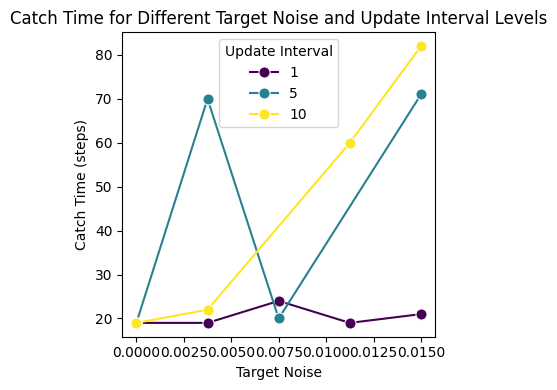

In [ ]:
import do_mpc
import numpy as np
import matplotlib.pyplot as plt
from casadi import SX
import pandas as pd
import seaborn as sns

# Define parameters
target_noise_levels = np.linspace(0.00, 0.015, 5)
update_intervals = [1, 5, 10]  # Different update intervals to test
cost = 2
catch_threshold = 0.01  # Threshold for catching the target (distance)
n_steps = 150

# Define model
def create_model():
    model_type = 'continuous'
    model = do_mpc.model.Model(model_type)

    # States (target: x_t, y_t | agent: x_a, y_a)
    x_t = model.set_variable(var_type='_x', var_name='x_t', shape=(1,1))
    y_t = model.set_variable(var_type='_x', var_name='y_t', shape=(1,1))
    x_a = model.set_variable(var_type='_x', var_name='x_a', shape=(1,1))
    y_a = model.set_variable(var_type='_x', var_name='y_a', shape=(1,1))

    # Controls (velocity for the agent)
    u_x = model.set_variable(var_type='_u', var_name='u_x', shape=(1,1))
    u_y = model.set_variable(var_type='_u', var_name='u_y', shape=(1,1))

    # Target moves predictably
    v_t = SX(0.2)  # Constant velocity as a CasADi SX variable
    x_t_dot = v_t*1  # Moves to the right
    y_t_dot = v_t*1  # Moves up

    # State equations
    model.set_rhs('x_a', u_x)
    model.set_rhs('y_a', u_y)
    model.set_rhs('x_t', x_t_dot)
    model.set_rhs('y_t', y_t_dot)

    model.setup()
    return model

# Create MPC controller
def create_mpc(model, update_interval):
    mpc = do_mpc.controller.MPC(model)
    setup_mpc = {
        'n_horizon': 20,  # Keeping horizon fixed for simplicity
        't_step': 0.1,
        'n_robust': 0,
        'store_full_solution': True,
    }
    mpc.set_param(**setup_mpc)

    # Define cost function
    x_a, y_a, x_t, y_t = model.x['x_a'], model.x['y_a'], model.x['x_t'], model.x['y_t']
    goal_cost = cost * (x_a - x_t)**2 + cost * (y_a - y_t)**2
    mpc.set_objective(mterm=goal_cost, lterm=goal_cost)

    # Control bounds
    mpc.bounds['lower', '_u', 'u_x'] = -0.3
    mpc.bounds['upper', '_u', 'u_x'] = 0.3
    mpc.bounds['lower', '_u', 'u_y'] = -0.3
    mpc.bounds['upper', '_u', 'u_y'] = 0.3

    mpc.setup()
    return mpc

# Create simulator
def create_simulator(model):
    simulator = do_mpc.simulator.Simulator(model)
    simulator.set_param(t_step=0.1)
    simulator.setup()
    return simulator

# Function to calculate the time when the agent catches the target
def calculate_catch_time(target_noise, update_interval, n_steps):
    model = create_model()
    mpc = create_mpc(model, update_interval)
    simulator = create_simulator(model)

    # Initial state
    x0 = np.array([[0.0], [0.0], [0.0], [1.0]])  # Blue at (0,0), Red at (1,1)
    mpc.x0 = x0
    simulator.x0 = x0
    mpc.set_initial_guess()

    # Simulate
    x_current = x0
    caught = False
    counter = 0
    catch_time = None
    for t in range(n_steps):
        if counter % update_interval == 0:  # Only compute the optimal control every 'update_interval' steps
            u = mpc.make_step(x_current)  # Recompute control trajectory
        else:
            u = mpc.u0  # Use the same control input as the previous step

        x_current = simulator.make_step(u)  # Apply the control input to the simulator
        counter += 1

        # Add noise to the target's movement (but NOT to the agent)
        x_current[0] += np.random.normal(0, target_noise)  # Noise in x_t
        x_current[1] += np.random.normal(0, target_noise)  # Noise in y_t

        # Check if the agent has caught the target (within catch_threshold distance)
        distance = np.sqrt((x_current[2] - x_current[0])**2 + (x_current[3] - x_current[1])**2)
        if not caught and distance < catch_threshold:
            caught = True
            catch_time = t

    return catch_time

# Calculate catch times for each combination of target_noise and update_interval
catch_times = {}

for target_noise in target_noise_levels:
    for update_interval in update_intervals:
        catch_time = calculate_catch_time(target_noise, update_interval, n_steps)
        catch_times[(target_noise, update_interval)] = catch_time

# Prepare data for the plot
catch_time_data = []
for target_noise in target_noise_levels:
    for update_interval in update_intervals:
        catch_time_data.append({
            'Target Noise': target_noise,
            'Update Interval': update_interval,
            'Catch Time': catch_times.get((target_noise, update_interval), np.nan)
        })

# Create a DataFrame
df = pd.DataFrame(catch_time_data)

# Plotting the results using seaborn
plt.figure(figsize=(4, 4))
sns.lineplot(data=df, x='Target Noise', y='Catch Time', hue='Update Interval', marker='o', linestyle='-', markersize=8, palette="viridis")

# Add labels and title
plt.xlabel('Target Noise')
plt.ylabel('Catch Time (steps)')
plt.title('Catch Time for Different Target Noise and Update Interval Levels')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
df

,Target Noise,Update Interval,Catch Time
0,0.00000,1,19.0
1,0.00000,5,19.0
2,0.00000,10,19.0
3,0.00375,1,20.0
4,0.00375,5,30.0
5,0.00375,10,20.0
6,0.00750,1,19.0
7,0.00750,5,21.0
8,0.00750,10,NaN
9,0.01125,1,21.0
